<a href="https://colab.research.google.com/github/sokrypton/ColabDesign/blob/beta/af/examples/design_fixbb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AfDesign (beta version)
Backprop through AlphaFold for protein design.

**WARNING**
1.   This notebook is in active development and was designed for demonstration purposes only.
2.   Using AfDesign as the only "loss" function for design might be a bad idea, you may find adversarial sequences (aka. sequences that trick AlphaFold).
3.   The current setup is limited to max length of ~256 amino acids length.

In [1]:
#@title install
%%bash
if [ ! -d af_backprop ]; then
  git clone https://github.com/sokrypton/af_backprop.git
  pip -q install biopython dm-haiku==0.0.5 ml-collections py3Dmol
fi
if [ ! -d params ]; then
  mkdir params
  curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params
fi
wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py

In [2]:
%%writefile design.py
import random, copy
import numpy as np
import jax
import jax.numpy as jnp
from jax.example_libraries.optimizers import sgd, adam

def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

from alphafold.common import protein
from alphafold.data import pipeline, templates
from alphafold.model import data, config, model, modules
from alphafold.common import residue_constants

from alphafold.model import all_atom
from alphafold.model import folding

# custom functions
from utils import *
import colabfold as cf

import py3Dmol
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

class mk_design_model:
  ######################################
  # model initialization
  ######################################
  def __init__(self):

    # decide if templates should be used    
    self._default_opt = {"temp":1.0, "soft":0.0, "hard":0.0, "dropout":True, "dropout_scale":1.0, "gumbel":False}

    # setup which model params to use
    model_name = "model_3_ptm"
    
    cfg = config.model_config(model_name)

    # enable checkpointing
    cfg.model.global_config.use_remat = True

    # subbatch_size / chunking
    cfg.model.global_config.subbatch_size = None

    # number of sequences
    cfg.data.eval.max_msa_clusters = 1
    cfg.data.common.max_extra_msa = 1
    cfg.data.eval.masked_msa_replace_fraction = 0

    # number of recycles
    cfg.model.num_recycle = 0
    cfg.data.common.num_recycle = 0

    self._config = cfg

    # setup model
    self._model_params = [data.get_model_haiku_params(model_name=model_name, data_dir=".")]
    self._runner = model.RunModel(self._config, self._model_params[0], is_training=True)

    # load the other model_params
    model_names = ["model_1_ptm","model_2_ptm","model_4_ptm","model_5_ptm"]
    for model_name in model_names:
      params = data.get_model_haiku_params(model_name, '.')
      self._model_params.append({k: params[k] for k in self._runner.params.keys()})

    # define gradient function
    self._grad_fn, self._fn = [jax.jit(x) for x in _get_fn(self)]

    # define input function
    self.prep_inputs = self._prep_fixbb
  
  ######################################
  # input prep functions
  ######################################

  def _prep_features(self, length, template_features=None):
    '''process features'''
    num_seq = 1
    sequence = "A" * length
    feature_dict = {
        **pipeline.make_sequence_features(sequence=sequence, description="none", num_res=length),
        **pipeline.make_msa_features(msas=[length*[sequence]], deletion_matrices=[num_seq*[[0]*length]])
    }
    if template_features is not None: feature_dict.update(template_features)    
    inputs = self._runner.process_features(feature_dict, random_seed=0)
    if num_seq > 1:
      inputs["msa_row_mask"] = jnp.ones_like(inputs["msa_row_mask"])
      inputs["msa_mask"] = jnp.ones_like(inputs["msa_mask"])
    return inputs

  def _prep_pdb(self, pdb_filename, chain=None):
    '''extract features from pdb'''
    if chain is None: chains = [None]
    else: chains = chain.split(",")
    o,last = [],0
    for chain in chains:
      protein_obj = protein.from_pdb_string(pdb_to_string(pdb_filename), chain_id=chain)
      batch = {'aatype': protein_obj.aatype,
              'all_atom_positions': protein_obj.atom_positions,
              'all_atom_mask': protein_obj.atom_mask}

      has_ca = batch["all_atom_mask"][:,0] == 1
      batch = jax.tree_map(lambda x:x[has_ca], batch)
      batch.update(all_atom.atom37_to_frames(**batch))

      template_features = {"template_aatype":jax.nn.one_hot(protein_obj.aatype[has_ca],22),
                          "template_all_atom_masks":protein_obj.atom_mask[has_ca],
                          "template_all_atom_positions":protein_obj.atom_positions[has_ca]}
      
      residue_index = protein_obj.residue_index[has_ca] + last
      last = residue_index[-1] + 50
      o.append({"batch":batch,
                "template_features":template_features,
                "residue_index": residue_index})
    o = jax.tree_multimap(lambda *x:np.concatenate(x,0),*o)
    o["template_features"] = {"template_domain_names":np.asarray(["None"]),
                              **jax.tree_map(lambda x:x[None],o["template_features"])}
    return o                          

  def _prep_fixbb(self, pdb_filename, chain=None, **kwargs):
    '''prep inputs for fixed backbone design'''
    pdb = self._prep_pdb(pdb_filename, chain=chain)
    self._batch = pdb["batch"]
    self._wt_aatype = self._batch["aatype"]
    self._len = pdb["residue_index"].shape[0]
    self._inputs = self._prep_features(self._len, pdb["template_features"])    
    # set weights
    self._default_weights = {"dgram_cce":1.0, "fape":0.0, "rmsd":0.0}
    self._inputs["residue_index"] = pdb["residue_index"][None]
    self.restart(**kwargs)

  #################################
  # initialization/restart function
  #################################
  def _setup_optimizer(self, optimizer="sgd", lr_scale=1.0, **kwargs):
    '''setup which optimizer to use'''
    if optimizer == "adam":
      optimizer = adam
      lr = 0.02 * lr_scale
    else:
      optimizer = sgd
      lr = 0.1 * lr_scale
    self._init_fun, self._update_fun, self._get_params = optimizer(lr, **kwargs)
    self._k = 0

  def _init_seq(self, x=None):
    '''initialize sequence'''
    self._key, _key = jax.random.split(self._key)
    shape = (1, self._len, 20)
    if isinstance(x, np.ndarray) or isinstance(x, jnp.ndarray):
      y = jnp.broadcast_to(x, shape)
    elif isinstance(x, str):
      if len(x) == self._len:
        y = jax.nn.one_hot(jnp.array([residue_constants.restype_order.get(aa,-1) for aa in x]),20)
        y = jnp.broadcast_to(2 * y, shape)
      else:
        if "wt" in x or "wildtype" in x:
          y = jax.nn.one_hot(self._wt_aatype,20)
          y = jnp.broadcast_to(2 * y, shape)
        if "gumbel" in x: y = jax.random.gumbel(_key, shape)/2
        if "zeros" in x: y = jnp.zeros(shape)
        if "soft" in x: y = jax.nn.softmax(2 * y)
    else:
      y = 0.01 * jax.random.normal(_key, shape)
    self._params = {"seq":y}
    self._state = self._init_fun(self._params)

  def restart(self, weights=None, seed=None, seq_init="soft_gumbel", **kwargs):    
    
    # set weights and options
    self.opt = {"weights":self._default_weights.copy()}
    if weights is not None: self.opt["weights"].update(weights)
    self.opt.update(copy.deepcopy(self._default_opt))

    # setup optimizer
    self._setup_optimizer(**kwargs)    
    
    # initialize sequence
    self._seed = random.randint(0,2147483647) if seed is None else seed
    self._key = jax.random.PRNGKey(self._seed)
    self._init_seq(seq_init)

    # initialize trajectory
    self.losses,self._traj = [],{"xyz":[],"seq":[],"plddt":[],"pae":[]}
    self._best_loss, self._best_outs = np.inf, None

  ######################################
  # STEP FUNCTION
  ######################################
  def _step(self, weights=None, lr_scale=1.0, **kwargs):
    '''do one step'''

    if weights is not None: self.opt["weights"].update(weights)
    
    # get current params
    self._params = self._get_params(self._state)

    # decide which model params to use
    self._key, *keys = jax.random.split(self._key, 3)
    self._model_num = int(jax.random.choice(keys[0],jnp.arange(5),[],replace=False))
    
    # update loss/outs/gradient
    (self._loss, self._outs), self._grad = self._grad_fn(self._params, self._model_params[self._model_num],
                                                        self._inputs, keys[1], self.opt)
    self._losses = self._outs["losses"] 

    # normalize gradient
    g = self._grad["seq"]
    gn = jnp.linalg.norm(g,axis=(-1,-2),keepdims=True)
    self._grad["seq"] *= lr_scale * jnp.sqrt(self._len)/(gn+1e-7)

    # apply gradient
    self._state = self._update_fun(self._k, self._grad, self._state)
    self._k += 1
    _save_results(self, **kwargs)


  ##############################################################################
  # DESIGN FUNCTIONS
  ##############################################################################
  def design(self, iters,
              temp=1.0, e_temp=None,
              soft=False, e_soft=None,
              hard=False, dropout=True, gumbel=False, **kwargs):
    self.opt.update({"hard":1.0 if hard else 0.0,"dropout":dropout,"gumbel":gumbel})
    if e_soft is None: e_soft = soft
    if e_temp is None: e_temp = temp
    for i in range(iters):
      self.opt["temp"] = e_temp + (temp - e_temp) * (1-i/(iters-1)) ** 2
      self.opt["soft"] = soft + (e_soft - soft) * i/(iters-1)
      # decay learning rate based on temperature
      lr_scale = (1 - self.opt["soft"]) + (self.opt["soft"] * self.opt["temp"])
      self._step(lr_scale=lr_scale, **kwargs)

  def design_logits(self, iters, **kwargs):
    '''optimize logits'''
    self.design(iters, **kwargs)

  def design_soft(self, iters, **kwargs):
    ''' optimize softmax(logits/temp)'''
    self.design(iters, soft=True, **kwargs)
  
  def design_hard(self, iters, **kwargs):
    ''' optimize argmax(logits)'''
    self.design(iters, soft=True, hard=True, **kwargs)

  def design_2stage(self, soft_iters=100, temp_iters=100, hard_iters=50,
                    temp=1.0, dropout=True, gumbel=False, **kwargs):
    '''two stage design (soft→hard)'''
    self.design(soft_iters, soft=True, temp=temp, dropout=dropout, gumbel=gumbel, **kwargs)
    self.design(temp_iters, soft=True, temp=temp, dropout=dropout, gumbel=False,  e_temp=1e-2, **kwargs)
    self.design(hard_iters, soft=True, temp=1e-2, dropout=False,   gumbel=False,  hard=True, save_best=True, **kwargs)

  def design_3stage(self, soft_iters=300, temp_iters=100, hard_iters=50, 
                    temp=1.0, dropout=True, gumbel=False, **kwargs):
    '''three stage design (logits→soft→hard)'''
    self.design(soft_iters, e_soft=True, temp=temp, dropout=dropout, gumbel=gumbel, **kwargs)
    self.design(temp_iters, soft=True,   temp=temp, dropout=dropout, gumbel=False, e_temp=1e-2,**kwargs)
    self.design(hard_iters, soft=True,   temp=1e-2, dropout=False,   gumbel=False, hard=True, save_best=True, **kwargs)    
  ######################################
  # utils
  ######################################
  def get_seqs(self):
    outs = self._outs if self._best_outs is None else self._best_outs
    outs = jax.tree_map(lambda x:np.asarray(x), outs)
    x = np.array(outs["seq"]).argmax(-1)
    return ["".join([order_restype[a] for a in s]) for s in x]
  
  def get_loss(self, x="loss"):
    '''output the loss (for entire trajectory)'''
    return np.array([float(loss[x]) for loss in self.losses])

  def save_pdb(self, filename=None):
    '''save pdb coordinates'''
    outs = self._outs if self._best_outs is None else self._best_outs
    outs = jax.tree_map(lambda x:np.asarray(x), outs)
    aatype = outs["seq"].argmax(-1)[0]
    p = {"residue_index":self._inputs["residue_index"][0],
          "aatype":aatype,
          "atom_positions":outs["final_atom_positions"],
          "atom_mask":outs["final_atom_mask"]}
    b_factors = outs["plddt"][:,None] * p["atom_mask"]
    p = protein.Protein(**p,b_factors=b_factors)
    pdb_lines = protein.to_pdb(p)
    if filename is None:
      return pdb_lines
    else:
      with open(filename, 'w') as f: f.write(pdb_lines)
  
  ######################################
  # plotting functions
  ######################################
  def animate(self, s=0, e=None, dpi=100):
    sub_traj = {k:v[s:e] for k,v in self._traj.items()}
    pos_ref = self._batch["all_atom_positions"][:,1,:]
    return make_animation(**sub_traj, pos_ref=pos_ref, length=None, dpi=dpi)
    
  def plot_pdb(self):
    '''use py3Dmol to plot pdb coordinates'''
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    view.addModel(self.save_pdb(),'pdb')
    view.setStyle({'cartoon': {}})
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
    view.zoomTo()
    view.show()
  
  def plot_traj(self, dpi=100):
    fig = plt.figure(figsize=(5,5), dpi=dpi)
    gs = GridSpec(4,1, figure=fig)
    ax1 = fig.add_subplot(gs[:3,:])
    ax2 = fig.add_subplot(gs[3:,:])
    ax1_ = ax1.twinx()
    
    rmsd = self.get_loss("rmsd")
    for k in [0.5,1,2,4,8,16,32]:
      ax1.plot([0,len(rmsd)],[k,k],color="lightgrey")
    ax1.plot(rmsd,color="black")
    ax1_.plot(self.get_loss("seqid"),color="green",label="seqid")
    # axes labels
    ax1.set_yscale("log")
    ticks = [0.25,0.5,1,2,4,8,16,32,64]
    ax1.set(xticks=[])
    ax1.set_yticks(ticks);ax1.set_yticklabels(ticks)
    ax1.set_ylabel("RMSD",color="black");ax1_.set_ylabel("seqid",color="green")
    ax1.set_ylim(0.25,64)
    ax1_.set_ylim(0,0.4)
    # extras
    if "soft" in self.losses[0]:
      ax2.plot(self.get_loss("soft"),color="yellow",label="soft")
    if "temp" in self.losses[0]:
      ax2.plot(self.get_loss("temp"),color="orange",label="temp")
    if "hard" in self.losses[0]:
      ax2.plot(self.get_loss("hard"),color="red",label="hard")
    ax2.set_ylim(-0.1,1.1)
    ax2.set_xlabel("iterations")
    ax2.legend(loc='center left')
    plt.show()

######################################
# SETUP LOSS FUNCTION
######################################
def _get_fn(self):

  # setup function to get gradients
  def mod(params, model_params, inputs, key, opt):

    # initialize the loss function
    losses = {}
    w = opt["weights"]

    # set sequence
    seq = params["seq"] - params["seq"].mean(-1,keepdims=True)

    # straight-through/reparameterization
    seq_logits = 2.0 * seq + jnp.where(opt["gumbel"], jax.random.gumbel(key,seq.shape), 0.0)
    seq_soft = jax.nn.softmax(seq_logits / opt["temp"])
    seq_hard = jax.nn.one_hot(seq_soft.argmax(-1), 20)
    seq_hard = jax.lax.stop_gradient(seq_hard - seq_soft) + seq_soft

    # create pseudo sequence
    seq_pseudo = opt["soft"] * seq_soft + (1-opt["soft"]) * seq
    seq_pseudo = opt["hard"] * seq_hard + (1-opt["hard"]) * seq_pseudo
    
    # save for aux output
    aux = {"seq":seq_hard,"seq_pseudo":seq_pseudo}
    
    # update sequence
    update_seq(seq_pseudo, inputs)
    
    # update amino acid sidechain identity
    N,L = inputs["aatype"].shape[:2]
    aatype = jnp.broadcast_to(jax.nn.one_hot(seq_pseudo[0].argmax(-1),21),(N,L,21))
    update_aatype(aatype, inputs)
    
    # scale dropout rate
    inputs["scale_rate"] = jnp.where(opt["dropout"],jnp.full(1,opt["dropout_scale"]),jnp.zeros(1))
    
    # get outputs
    outputs = self._runner.apply(model_params, key, inputs)

    fape_loss = get_fape_loss(self._batch, outputs, model_config=self._config)      
    dgram_cce_loss = get_dgram_loss(self._batch, outputs, model_config=self._config)
    rmsd_loss = get_rmsd_loss_w(self._batch, outputs)
    losses.update({"dgram_cce":dgram_cce_loss, "fape":fape_loss, "rmsd":rmsd_loss})

    # loss
    loss = sum([v*w[k] if k in w else v*0 for k,v in losses.items()])

    # save aux outputs
    aux.update({"final_atom_positions":outputs["structure_module"]["final_atom_positions"],
                "final_atom_mask":outputs["structure_module"]["final_atom_mask"],
                "plddt":get_plddt(outputs),
                "losses":losses})

    return loss, (aux)
  
  return jax.value_and_grad(mod, has_aux=True, argnums=0), mod
    
def _save_results(self, save_best=False, verbose=True):
  '''save the results and update trajectory'''

  # save best result
  if save_best and self._loss < self._best_loss:
    self._best_loss = self._loss
    self._best_outs = self._outs
  
  # compile losses
  self._losses.update({"model":self._model_num,"loss":self._loss, 
                       **{k:self.opt[k] for k in ["soft","hard","temp"]}})
  
  # compute sequence recovery
  _aatype = self._outs["seq"].argmax(-1)
  L = min(_aatype.shape[-1], self._wt_aatype.shape[-1])
  seqid = (_aatype[...,:L] == self._wt_aatype[...,:L]).mean()
  self._losses.update({"seqid":seqid})

  # save losses
  self.losses.append(self._losses)

  # print losses      
  if verbose:
    I = ["model","recycles"]
    f = ["soft","temp","seqid"]
    F = ["loss","dgram_cce","fape","rmsd"]
    I = " ".join([f"{x}: {self._losses[x]}" for x in I if x in self._losses])
    f = " ".join([f"{x}: {self._losses[x]:.2f}" for x in f if x in self._losses])
    F = " ".join([f"{x}: {self._losses[x]:.2f}" for x in F if x in self._losses])
    print(f"{self._k}\t{I} {f} {F}")

  # save trajectory
  ca_xyz = self._outs["final_atom_positions"][:,1,:]
  traj = {"xyz":ca_xyz,"plddt":self._outs["plddt"],"seq":self._outs["seq_pseudo"]}
  if "pae" in self._outs: traj.update({"pae":self._outs["pae"]})
  for k,v in traj.items(): self._traj[k].append(np.array(v))

#####################################################################
# UTILS
#####################################################################
def make_animation(xyz, seq, plddt=None, pae=None,
                   pos_ref=None, line_w=2.0,
                   dpi=100, interval=60, color_msa="Taylor",
                   length=None):

  def align(P, Q, P_trim=None):
    if P_trim is None: P_trim = P
    p_trim = P_trim - P_trim.mean(0,keepdims=True)
    p = P - P_trim.mean(0,keepdims=True)
    q = Q - Q.mean(0,keepdims=True)
    return p @ cf.kabsch(p_trim,q)

  # compute reference position
  if pos_ref is None: pos_ref = xyz[-1]
  if length is None: length = len(pos_ref)
  
  # align to reference
  pos_ref_trim = pos_ref[:length]
  # align to reference position
  new_positions = []
  for i in range(len(xyz)):
    new_positions.append(align(xyz[i],pos_ref_trim,xyz[i][:length]))
  pos = np.asarray(new_positions)

  # rotate for best view
  pos_mean = np.concatenate(pos,0)
  m = pos_mean.mean(0)
  rot_mtx = cf.kabsch(pos_mean - m, pos_mean - m, return_v=True)
  pos = (pos - m) @ rot_mtx + m
  pos_ref_full = ((pos_ref - pos_ref_trim.mean(0)) - m) @ rot_mtx + m

  # initialize figure
  if pae is not None and len(pae) == 0: pae = None
  fig = plt.figure()
  gs = GridSpec(4,3, figure=fig)
  if pae is not None:
    ax1, ax2, ax3 = fig.add_subplot(gs[:3,:2]), fig.add_subplot(gs[3:,:]), fig.add_subplot(gs[:3,2:])
  else:
    ax1, ax2 = fig.add_subplot(gs[:3,:]), fig.add_subplot(gs[3:,:])

  fig.subplots_adjust(top=0.95,bottom=0.1,right=0.95,left=0.05,hspace=0,wspace=0)
  fig.set_figwidth(8); fig.set_figheight(6); fig.set_dpi(dpi)
  ax2.set_xlabel("positions"); ax2.set_yticks([])
  if seq[0].shape[0] > 1: ax2.set_ylabel("sequences")
  else: ax2.set_ylabel("amino acids")

  ax1.set_title("N→C") if plddt is None else ax1.set_title("pLDDT")
  if pae is not None:
    ax3.set_title("pAE")
    ax3.set_xticks([])
    ax3.set_yticks([])

  # set bounderies
  x_min,y_min,z_min = np.minimum(np.mean(pos.min(1),0),pos_ref_full.min(0)) - 5
  x_max,y_max,z_max = np.maximum(np.mean(pos.max(1),0),pos_ref_full.max(0)) + 5

  x_pad = ((y_max - y_min) * 2 - (x_max - x_min)) / 2
  y_pad = ((x_max - x_min) / 2 - (y_max - y_min)) / 2
  if x_pad > 0:
    x_min -= x_pad
    x_max += x_pad
  else:
    y_min -= y_pad
    y_max += y_pad

  ax1.set_xlim(x_min, x_max)
  ax1.set_ylim(y_min, y_max)
  ax1.set_xticks([])
  ax1.set_yticks([])

  # get animation frames
  ims = []
  for k in range(len(pos)):
    ims.append([])
    if plddt is None:
      ims[-1].append(cf.plot_pseudo_3D(pos[k], ax=ax1, line_w=line_w, zmin=z_min, zmax=z_max))
    else:
      ims[-1].append(cf.plot_pseudo_3D(pos[k], c=plddt[k], cmin=0.5, cmax=0.9, ax=ax1, line_w=line_w, zmin=z_min, zmax=z_max))
    if seq[k].shape[0] == 1:
      ims[-1].append(ax2.imshow(seq[k][0].T, animated=True, cmap="bwr_r",vmin=-1, vmax=1))
    else:
      cmap = matplotlib.colors.ListedColormap(jalview_color_list[color_msa])
      vmax = len(jalview_color_list[color_msa]) - 1
      ims[-1].append(ax2.imshow(seq[k].argmax(-1), animated=True, cmap=cmap, vmin=0, vmax=vmax, interpolation="none"))
    if pae is not None:
      ims[-1].append(ax3.imshow(pae[k], animated=True, cmap="bwr",vmin=0, vmax=30))

  # make animation!
  ani = animation.ArtistAnimation(fig, ims, blit=True, interval=interval)
  plt.close()
  return ani.to_html5_video()

Overwriting design.py


In [3]:
#@title import libraries
import os
os.environ['TF_CUDNN_DETERMINISTIC']='1'

import sys
sys.path.append('/content/af_backprop')

from google.colab import files
import numpy as np
from IPython.display import HTML
from design import mk_design_model, clear_mem

#########################
def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  else:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"

# fixed backbone design (fixbb)
For a given protein backbone, generate/design a new sequence that AlphaFold thinks folds into that conformation. 

In [4]:
clear_mem()
model = mk_design_model()
model.prep_inputs(pdb_filename=get_pdb("1TEN"), chain="A")

print("length",  model._len)
print("weights", model.opt["weights"])

length 89
weights {'dgram_cce': 1.0, 'fape': 0.0, 'rmsd': 0.0}


In [5]:
model.restart(seed=0)
model.design_3stage()

1	model: 4 soft: 0.00 temp: 1.00 seqid: 0.03 loss: 5.35 dgram_cce: 5.35 fape: 5.24 rmsd: 40.11
2	model: 3 soft: 0.00 temp: 1.00 seqid: 0.03 loss: 4.01 dgram_cce: 4.01 fape: 3.36 rmsd: 27.45
3	model: 0 soft: 0.01 temp: 1.00 seqid: 0.02 loss: 3.66 dgram_cce: 3.66 fape: 2.40 rmsd: 17.81
4	model: 4 soft: 0.01 temp: 1.00 seqid: 0.02 loss: 3.84 dgram_cce: 3.84 fape: 3.16 rmsd: 25.04
5	model: 2 soft: 0.01 temp: 1.00 seqid: 0.01 loss: 4.03 dgram_cce: 4.03 fape: 2.32 rmsd: 16.44
6	model: 3 soft: 0.02 temp: 1.00 seqid: 0.02 loss: 3.49 dgram_cce: 3.49 fape: 2.20 rmsd: 15.29
7	model: 1 soft: 0.02 temp: 1.00 seqid: 0.01 loss: 3.33 dgram_cce: 3.33 fape: 2.08 rmsd: 14.95
8	model: 4 soft: 0.02 temp: 1.00 seqid: 0.02 loss: 3.29 dgram_cce: 3.29 fape: 1.96 rmsd: 13.04
9	model: 2 soft: 0.03 temp: 1.00 seqid: 0.02 loss: 3.28 dgram_cce: 3.28 fape: 1.90 rmsd: 13.64
10	model: 3 soft: 0.03 temp: 1.00 seqid: 0.02 loss: 3.22 dgram_cce: 3.22 fape: 2.08 rmsd: 16.11
11	model: 3 soft: 0.03 temp: 1.00 seqid: 0.02 los

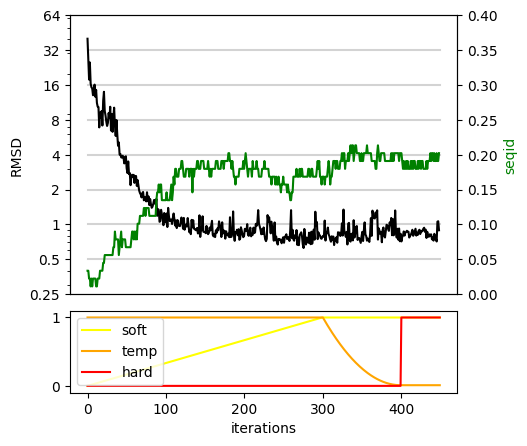

In [6]:
model.plot_traj()  

In [7]:
HTML(model.animate())

In [8]:
model.plot_pdb()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [9]:
model.save_pdb(f"design.pdb")

In [10]:
model.get_seqs()

['PPWVDGWTVSNVTDTKAYLSFAPPKEPVDYLVVWMHNAGDPGSERFYRLDPGFTSMWFSGLQPNTTFMFRVAAVKGDRQWPIKEKRTTC']